In [1]:
import torch.nn as nn,pandas as pd,torch
from torchvision import transforms
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from regDataset import binary_acc,RegDataset
from regModels import RegModelSeperateBlocks

In [2]:
dfTrain = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TrainReg.csv")
dfTrain.head()

Unnamed: 0       IoU  accuracy  \
0           0  0.525488  0.937097   
1           1  0.668481  0.952417   
2           2  0.298922  0.909215   
3           3  0.901852  0.976186   
4           4  0.869438  0.968593   

                                            predMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                              gtMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            RecInput  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            InputImg  Epoch   Data  
0  /home/pictor/workspace/Akhil/Confidence/Data/R...    126  Train  
1  /home/pictor/workspace/Akhil/Confidence/Data/R...     66  Train  
2  /home/pictor/workspace/Akhil/Confidence/Data/R...    156  Train  
3  /home/pictor/workspace/Akhil/Confidence/Data/R...    126  Train  
4  /home/pictor/workspace/Akhil/Confidence/Data/R...    161  Train

In [3]:
dfVal = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/ValReg.csv")
dfTest = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TestReg.csv")
dfTrain.shape,dfVal.shape,dfTest.shape

((13971, 9), (3570, 9), (2835, 9))

In [4]:
threshold = 0.8
metricCol = 'IoU'
label_function = lambda x: 0 if x<threshold else 1
dfTrain.loc[:,'label'] = dfTrain[metricCol].apply(label_function)
dfVal.loc[:,'label'] = dfVal[metricCol].apply(label_function)
dfTest.loc[:,'label'] = dfTest[metricCol].apply(label_function)


In [5]:
dfTest.head()

Unnamed: 0       IoU  accuracy  \
0       14803  0.529264  0.939565   
1       14805  0.764624  0.961272   
2       14806  0.000000  0.862231   
3       14808  0.878936  0.982976   
4       14810  0.136580  0.415025   

                                            predMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                              gtMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            RecInput  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            InputImg  Epoch  Data  label  
0  /home/pictor/workspace/Akhil/Confidence/Data/R...    161  Test      0  
1  /home/pictor/workspace/Akhil/Confidence/Data/R...    101  Test      0  
2  /home/pictor/workspace/Akhil/Confidence/Data/R...     71  Test      0  
3  /home/pictor/workspace/Akhil/Confidence/Data/R...     91  Test      1  
4  /home/pictor/workspace/Akhil/Confidence/Data/R...      1  Test      0

In [6]:
# import cv2 as cv
# from glob import glob
# imgs = glob("/home/pictor/workspace/Akhil/Confidence/Data/ResTrueGreenV2/clipped_tifs/*tif")
# w,h = [],[]
# for pth in imgs:
#     img = cv.imread(pth)
#     w.append(img.shape[1])
#     h.append(img.shape[0])

# ar = [l/b for l,b in zip(h,w)]
# np.percentile(w,[i*10 for i in range(11)])
# np.percentile(ar,[i*10 for i in range(11)])

In [7]:
dfTrain.label.value_counts(1)

0    0.531386
1    0.468614
Name: label, dtype: float64

In [8]:
dfVal.label.value_counts(1)

0    0.586275
1    0.413725
Name: label, dtype: float64

In [9]:
dfTest.label.value_counts(1)

0    0.522751
1    0.477249
Name: label, dtype: float64

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
im_size = 256
preprocess_rgb = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,), std=(0.229,)),
])

In [12]:
batch_size = 64
train_dataset = RegDataset(dfTrain,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device,flip=True)
val_dataset = RegDataset(dfVal,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

test_dataset = RegDataset(dfTest,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)


In [13]:
n_epochs = 100
val_freq = 3
model = RegModelSeperateBlocks()
model.to(device)
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95,verbose=True)

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

Adjusting learning rate of group 0 to 5.0000e-03.


In [14]:
model_save_path = '/home/pictor/workspace/Akhil/Confidence/codes/regModels/trainRegSeperateBlocks.pt'
mxAcc = max(accuracy_stats['val']) if accuracy_stats['val'] else 0
for epoch in range(1,n_epochs+1):
    model.train()
    t = time()
    # if epoch!=1:
    train_epoch_loss = train_epoch_acc = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        y_pred_train = model(batch).squeeze()
        loss = lossFn(y_pred_train,batch['Y'].to(device))
        acc = binary_acc(y_pred_train,batch['Y'].to(device))
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss
        train_epoch_acc += acc
    if epoch%val_freq==0 or epoch==1:
        with torch.no_grad():
            model.eval()
            val_epoch_loss = val_epoch_acc = 0
            for val_batch in tqdm(val_dataloader):
                y_pred_val = model(val_batch).squeeze()
                val_loss = lossFn(y_pred_val,val_batch['Y'].to(device))
                val_acc = binary_acc(y_pred_val,val_batch['Y'].to(device))
                val_epoch_loss += val_loss
                val_epoch_acc += val_acc

            loss_stats['val'].append(val_epoch_loss/len(val_dataloader))
            accuracy_stats['val'].append(val_epoch_acc/len(val_dataloader))

            if val_acc > mxAcc:
                torch.save(model,model_save_path)
                mxAcc = val_acc
    scheduler.step()
    time_taken = time()-t
    loss_stats['train'].append(train_epoch_loss/len(train_dataloader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataloader))

    if epoch%val_freq==0 or epoch==1:
        print(f'Epoch {epoch+0:02}, Time {time_taken:.2f}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Val Loss: {val_epoch_loss/len(val_dataloader):.5f} |\
         Train Acc: {train_epoch_acc/len(train_dataloader):.3f}| Val Acc: {val_epoch_acc/len(val_dataloader):.3f}')
    else:
        print(f'Epoch {epoch+0:02}, Time {time_taken:.2f}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Train Acc: {train_epoch_acc/len(train_dataloader):.3f}|')

  0%|          | 0/437 [00:00<?, ?it/s]/home/pictor/.virtualenvs/ml_g6/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 01, Time 1243.71: | Train Loss: 0.73520 | Val Loss: 0.57310 |         Train Acc: 63.753| Val Acc: 69.616


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 02, Time 1043.47: | Train Loss: 0.56143 | Train Acc: 71.325|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 03, Time 1037.62: | Train Loss: 0.53626 | Val Loss: 0.60009 |         Train Acc: 72.693| Val Acc: 69.955


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 04, Time 821.16: | Train Loss: 0.51374 | Train Acc: 74.469|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
Epoch 05, Time 837.26: | Train Loss: 0.49082 | Train Acc: 76.034|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
Epoch 06, Time 1031.46: | Train Loss: 0.48493 | Val Loss: 0.57452 |         Train Acc: 76.508| Val Acc: 70.134


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
Epoch 07, Time 941.98: | Train Loss: 0.47663 | Train Acc: 76.918|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
Epoch 08, Time 921.96: | Train Loss: 0.46976 | Train Acc: 77.018|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
Epoch 09, Time 1102.30: | Train Loss: 0.47116 | Val Loss: 0.43218 |         Train Acc: 76.863| Val Acc: 79.482


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
Epoch 10, Time 904.79: | Train Loss: 0.45947 | Train Acc: 77.423|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
Epoch 11, Time 810.64: | Train Loss: 0.45794 | Train Acc: 77.732|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
Epoch 12, Time 1039.67: | Train Loss: 0.45522 | Val Loss: 0.43855 |         Train Acc: 77.716| Val Acc: 77.866


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
Epoch 13, Time 897.37: | Train Loss: 0.44329 | Train Acc: 78.833|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
Epoch 14, Time 855.09: | Train Loss: 0.43525 | Train Acc: 79.245|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
Epoch 15, Time 1106.44: | Train Loss: 0.42938 | Val Loss: 0.52329 |         Train Acc: 79.735| Val Acc: 72.286


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
Epoch 16, Time 912.52: | Train Loss: 0.41956 | Train Acc: 80.181|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
Epoch 17, Time 903.92: | Train Loss: 0.40994 | Train Acc: 80.600|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
Epoch 18, Time 1116.58: | Train Loss: 0.40678 | Val Loss: 0.45232 |         Train Acc: 80.886| Val Acc: 77.196


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
Epoch 19, Time 860.13: | Train Loss: 0.39891 | Train Acc: 81.169|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
Epoch 20, Time 787.58: | Train Loss: 0.39316 | Train Acc: 81.908|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
Epoch 21, Time 898.81: | Train Loss: 0.38445 | Val Loss: 0.47624 |         Train Acc: 82.611| Val Acc: 75.634


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
Epoch 22, Time 703.45: | Train Loss: 0.38254 | Train Acc: 82.522|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
Epoch 23, Time 813.03: | Train Loss: 0.37285 | Train Acc: 83.229|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
Epoch 24, Time 1017.30: | Train Loss: 0.37103 | Val Loss: 0.49564 |         Train Acc: 83.492| Val Acc: 74.375


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
Epoch 25, Time 777.21: | Train Loss: 0.36318 | Train Acc: 83.966|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
Epoch 26, Time 800.18: | Train Loss: 0.35496 | Train Acc: 84.247|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
Epoch 27, Time 1013.01: | Train Loss: 0.34787 | Val Loss: 0.50805 |         Train Acc: 84.414| Val Acc: 76.116


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
Epoch 28, Time 794.77: | Train Loss: 0.34403 | Train Acc: 85.018|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
Epoch 29, Time 829.99: | Train Loss: 0.34476 | Train Acc: 84.703|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
Epoch 30, Time 1021.49: | Train Loss: 0.33878 | Val Loss: 0.50076 |         Train Acc: 85.245| Val Acc: 75.027


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
Epoch 31, Time 762.50: | Train Loss: 0.32492 | Train Acc: 85.847|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
Epoch 32, Time 838.89: | Train Loss: 0.33121 | Train Acc: 85.400|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
Epoch 33, Time 1006.41: | Train Loss: 0.32575 | Val Loss: 0.53933 |         Train Acc: 85.792| Val Acc: 74.759


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
Epoch 34, Time 779.32: | Train Loss: 0.31033 | Train Acc: 86.737|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
Epoch 35, Time 819.94: | Train Loss: 0.30057 | Train Acc: 87.172|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
Epoch 36, Time 1027.71: | Train Loss: 0.29337 | Val Loss: 0.65374 |         Train Acc: 87.313| Val Acc: 73.688


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
Epoch 37, Time 784.91: | Train Loss: 0.28537 | Train Acc: 87.792|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
Epoch 38, Time 826.21: | Train Loss: 0.28367 | Train Acc: 87.721|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
Epoch 39, Time 1036.02: | Train Loss: 0.27906 | Val Loss: 0.78548 |         Train Acc: 88.126| Val Acc: 69.366


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
Epoch 40, Time 768.37: | Train Loss: 0.27281 | Train Acc: 88.318|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
Epoch 41, Time 851.79: | Train Loss: 0.25833 | Train Acc: 89.027|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
Epoch 42, Time 1024.41: | Train Loss: 0.26491 | Val Loss: 0.59017 |         Train Acc: 89.094| Val Acc: 76.062


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
Epoch 43, Time 768.03: | Train Loss: 0.25792 | Train Acc: 88.945|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
Epoch 44, Time 873.69: | Train Loss: 0.24369 | Train Acc: 89.920|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
Epoch 45, Time 1011.98: | Train Loss: 0.23129 | Val Loss: 0.65699 |         Train Acc: 90.529| Val Acc: 73.982


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
Epoch 46, Time 761.58: | Train Loss: 0.21948 | Train Acc: 90.867|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
Epoch 47, Time 862.18: | Train Loss: 0.21001 | Train Acc: 91.396|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
Epoch 48, Time 1051.37: | Train Loss: 0.20592 | Val Loss: 0.95323 |         Train Acc: 91.737| Val Acc: 73.366


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
Epoch 49, Time 794.85: | Train Loss: 0.20019 | Train Acc: 91.908|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
Epoch 50, Time 857.88: | Train Loss: 0.20103 | Train Acc: 91.581|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
Epoch 51, Time 1065.85: | Train Loss: 0.18642 | Val Loss: 0.98648 |         Train Acc: 92.412| Val Acc: 68.429


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
Epoch 52, Time 756.26: | Train Loss: 0.17898 | Train Acc: 93.094|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
Epoch 53, Time 864.46: | Train Loss: 0.18522 | Train Acc: 92.430|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
Epoch 54, Time 1053.49: | Train Loss: 0.16403 | Val Loss: 0.98013 |         Train Acc: 93.240| Val Acc: 71.625


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
Epoch 55, Time 763.05: | Train Loss: 0.17062 | Train Acc: 93.346|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
Epoch 56, Time 858.63: | Train Loss: 0.16417 | Train Acc: 93.410|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
Epoch 57, Time 1042.75: | Train Loss: 0.14653 | Val Loss: 0.91893 |         Train Acc: 94.350| Val Acc: 74.134


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
Epoch 58, Time 789.88: | Train Loss: 0.15210 | Train Acc: 93.936|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
Epoch 59, Time 851.70: | Train Loss: 0.14296 | Train Acc: 94.295|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
Epoch 60, Time 1058.45: | Train Loss: 0.13646 | Val Loss: 0.88524 |         Train Acc: 94.444| Val Acc: 77.330


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
Epoch 61, Time 774.75: | Train Loss: 0.12984 | Train Acc: 94.970|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
Epoch 62, Time 852.88: | Train Loss: 0.12335 | Train Acc: 95.302|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
Epoch 63, Time 1069.71: | Train Loss: 0.12410 | Val Loss: 1.07344 |         Train Acc: 95.005| Val Acc: 73.330


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
Epoch 64, Time 771.80: | Train Loss: 0.12578 | Train Acc: 95.073|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
Epoch 65, Time 872.46: | Train Loss: 0.11715 | Train Acc: 95.460|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
Epoch 66, Time 1088.41: | Train Loss: 0.11480 | Val Loss: 1.12264 |         Train Acc: 95.378| Val Acc: 74.679


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
Epoch 67, Time 751.06: | Train Loss: 0.10151 | Train Acc: 96.243|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
Epoch 68, Time 868.52: | Train Loss: 0.11484 | Train Acc: 95.389|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
Epoch 69, Time 1071.10: | Train Loss: 0.10901 | Val Loss: 1.07483 |         Train Acc: 95.767| Val Acc: 76.179


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
Epoch 70, Time 734.77: | Train Loss: 0.09935 | Train Acc: 96.297|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
Epoch 71, Time 844.85: | Train Loss: 0.09903 | Train Acc: 96.302|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
Epoch 72, Time 1066.08: | Train Loss: 0.09880 | Val Loss: 1.04110 |         Train Acc: 96.172| Val Acc: 76.580


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
Epoch 73, Time 780.17: | Train Loss: 0.08844 | Train Acc: 96.570|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
Epoch 74, Time 848.90: | Train Loss: 0.09624 | Train Acc: 96.217|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
Epoch 75, Time 1055.73: | Train Loss: 0.08180 | Val Loss: 1.18471 |         Train Acc: 96.808| Val Acc: 75.670


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
Epoch 76, Time 786.94: | Train Loss: 0.08669 | Train Acc: 96.835|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
Epoch 77, Time 865.58: | Train Loss: 0.07195 | Train Acc: 97.359|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
Epoch 78, Time 1037.43: | Train Loss: 0.08306 | Val Loss: 1.35135 |         Train Acc: 96.844| Val Acc: 75.839


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
Epoch 79, Time 783.37: | Train Loss: 0.07682 | Train Acc: 96.950|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
Epoch 80, Time 835.81: | Train Loss: 0.08577 | Train Acc: 96.773|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
Epoch 81, Time 1045.01: | Train Loss: 0.07662 | Val Loss: 1.23248 |         Train Acc: 97.089| Val Acc: 75.295


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
Epoch 82, Time 812.49: | Train Loss: 0.06363 | Train Acc: 97.723|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
Epoch 83, Time 852.16: | Train Loss: 0.08387 | Train Acc: 96.737|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
Epoch 84, Time 1053.62: | Train Loss: 0.07284 | Val Loss: 1.32377 |         Train Acc: 97.217| Val Acc: 76.188


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
Epoch 85, Time 793.24: | Train Loss: 0.07703 | Train Acc: 97.000|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
Epoch 86, Time 845.31: | Train Loss: 0.05683 | Train Acc: 97.927|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
Epoch 87, Time 1058.06: | Train Loss: 0.06815 | Val Loss: 1.37163 |         Train Acc: 97.622| Val Acc: 74.054


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
Epoch 88, Time 777.08: | Train Loss: 0.06059 | Train Acc: 97.716|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
Epoch 89, Time 829.60: | Train Loss: 0.06571 | Train Acc: 97.563|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
Epoch 90, Time 1052.11: | Train Loss: 0.07125 | Val Loss: 1.37687 |         Train Acc: 97.455| Val Acc: 74.875


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
Epoch 91, Time 815.52: | Train Loss: 0.05604 | Train Acc: 97.986|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
Epoch 92, Time 854.79: | Train Loss: 0.04611 | Train Acc: 98.449|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
Epoch 93, Time 1069.30: | Train Loss: 0.05485 | Val Loss: 1.40876 |         Train Acc: 97.952| Val Acc: 76.018


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
Epoch 94, Time 781.90: | Train Loss: 0.04816 | Train Acc: 98.490|


  0%|          | 0/437 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8868e-03.
Epoch 95, Time 861.54: | Train Loss: 0.05531 | Train Acc: 98.002|


 19%|█▉        | 83/437 [02:48<11:57,  2.03s/it]

KeyboardInterrupt: 

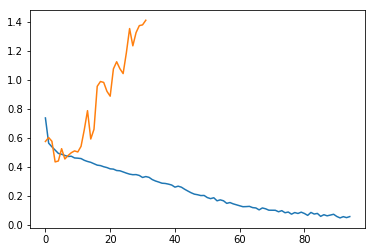

In [15]:
plt.plot(loss_stats['train']);
plt.plot(loss_stats['val']);

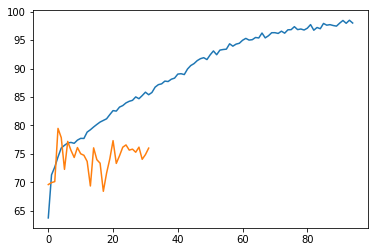

In [16]:
plt.plot(accuracy_stats['train']);
plt.plot(accuracy_stats['val']);